# Getting started with SBCK
## Preprocessing
### P.1 Packages

In [1]:
import sys,os
import pickle as pk

## Scientific libraries
##=====================
import numpy as np
import scipy.stats as sc
import SBCK as bc
import SBCK.metrics as bcm
import SBCK.datasets as bcd
import SBCK.tools as bct

## Plot libraries
##===============
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

### P.2 Custom classes

### P.3 Custom functions

### P.4 Custom plot functions

### P.5 Global parameters

## I. Definition of bias correction

Given two datasets $Y_0$ and $X_0$, called the *biased* and *reference* dataset, a *bias correction* is a method which transform the probability distribution of $X_0$ to the probability distribution of $Y_0$. Mathematically, a bias correction method is a map $\mathcal{T}$ such that:
- $Z_0 = \mathcal{T}(X_0)$, the corrected dataset,
- $\mathbb{P}_{Z_0} = \mathbb{P}_{Y_0}$, which follow the same law than $Y_0$,
- $\mathcal{T}(\mathbb{P}_{X_0}) = \mathbb{P}_{Y_0}$, transformed by $\mathcal{T}$.

This kind of methods are called a *stationary bias correction method*. Remark that this approach assumes that the probability distribution of $Y_0$ and $X_0$ do not change with time (the stationary assumption). Otherwise, some *non stationary bias correction method* learn how the BC is performed on a stationary part, and transform the method to other times.

## II. Univariate bias correction methods
Univariate bias corrections can only correct univariate time series, without taking into account of the dependence structure between variables. In this section, the following dataset will be used:

In [11]:
Y0,X0,X1 = bcd.gaussian_exp_mixture_1d(10000) ## From SBCK.datasets = bcd

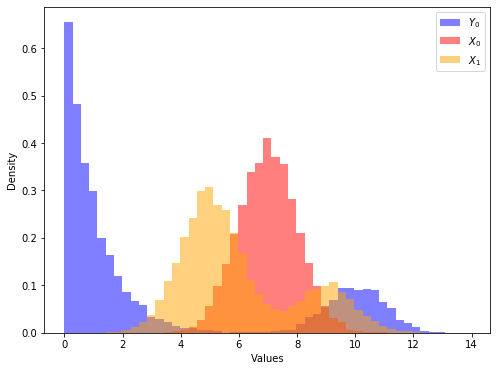

In [14]:
fig = plt.figure( figsize = (8,6) )

ax   = fig.add_subplot( 1 , 1 , 1 )
bins = np.linspace( min([T.min() for T in [Y0,X0,X1]]) , max([T.max() for T in [Y0,X0,X1]]) , 50 )
kwargs = { "bins" : bins , "alpha" : 0.5 , "density" : True }
ax.hist( Y0 , color = "blue"   , label = r"$Y_0$" , **kwargs )
ax.hist( X0 , color = "red"    , label = r"$X_0$" , **kwargs )
ax.hist( X1 , color = "orange" , label = r"$X_1$" , **kwargs )
ax.set_xlabel( "Values" )
ax.set_ylabel( "Density" )
ax.legend()
plt.show()

The hypothesis are that $Y_0$ is our "reference", $X_0$ is the model during calibraiton period, and $X_1$ the model during projection period.

### II.1 Stationary context: the quantile mapping

The quantile mapping method use a quantile-quantile map to perform the correction. Noting $F_{Y_0}$ the Cumulative Distribution Function (CDF) of $Y_0$ and $F_{X_0}$ the CDF of $X_0$, the QM method is defined as follow:

$$\mathcal{T} = F_{Y_0}^{-1}\circ F_{X_0}$$

This method is implemented in the class `SBCK.QM`. Without assumption, the empirical CDF is used:

In [21]:
qm = bc.QM()
qm.fit( Y0 , X0 )
Z0_e = qm.predict(X0) ## (e for empirical)

We can also assume that $X_0$ follow a normal law, the coefficients are fitted by `QM`:

In [22]:
qm = bc.QM( distX0 = sc.norm )
qm.fit( Y0 , X0 )
Z0_nf = qm.predict(X0) ## (nf for Normal Fitted)

Or give exactly the law of $X_0$:

In [25]:
qm = bc.QM( distX0 = sc.norm( loc = 7 , scale = 1. ) )
qm.fit( Y0 , X0 )
Z0_g = qm.predict(X0) ## (g for given)

A visual check show the good performance of the correction:

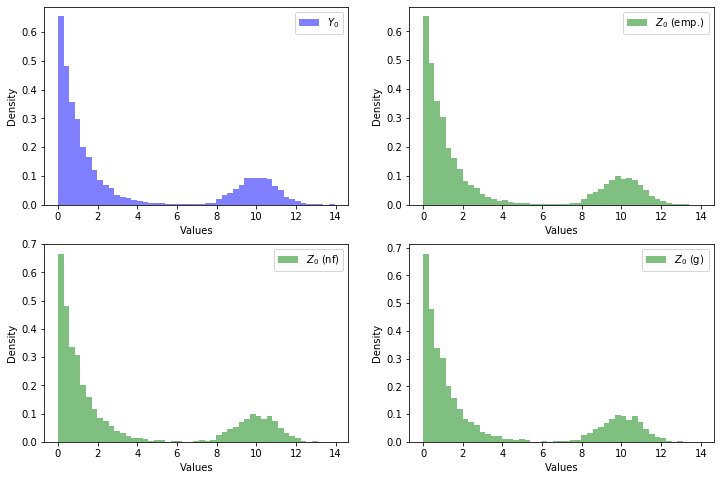

In [33]:
fig = plt.figure( figsize = (12,8) )

bins = np.linspace( min([T.min() for T in [Y0,X0,X1,Z0_e,Z0_nf,Z0_g]]) , max([T.max() for T in [Y0,X0,X1]]) , 50 )
label = [ r"$Y_0$" , r"$Z_0$ (emp.)" , r"$Z_0$ (nf)" , r"$Z_0$ (g)" ]
color = ["blue","green","green","green"]
kwargs = { "bins" : bins , "alpha" : 0.5 , "density" : True }
for i,Z in enumerate([Y0,Z0_e,Z0_nf,Z0_g]):
	ax   = fig.add_subplot( 2 , 2 , i + 1 )
	ax.hist( Z  , color = color[i] , label = label[i] , **kwargs )
	ax.set_xlabel( "Values" )
	ax.set_ylabel( "Density" )
	ax.legend()
plt.show()

Obviously, this method can not be used to correction $X_1$, because the distribution has changed with time. This is the goal of CDFt or QDM.

### II.2 Extension: CDFt method

Using quantile mapping, we have the following transformation:

- From $X_0$ to $X_1$ : $\mathcal{T}_{X} = F_{X_1}^{-1}\circ F_{X_0}$, the dynamic of the biased dataset,
- From $Y_0$ to $Y_1$ : $\mathcal{T}_{Y} = F_{Y_1}^{-1}\circ F_{Y_0}$, the dynamic of the reference,
- From $X_0$ to $Y_0$ : $\mathcal{T}_{XY} = F_{Y_0}^{-1}\circ F_{X_0}$, the bias between biased and reference dataset.

The method CDFt assume than the dynamic of the biased dataset and the reference are the same, i.e.:

$$\mathcal{T}_{X} = F_{X_1}^{-1}\circ F_{X_0}=F_{Y_1}^{-1}\circ F_{Y_0} = \mathcal{T}_{Y}$$

By re-arranging the CDF, we find the CDF of $Y_1$:

$$F_{Y_1} = F_{Y_0} \circ F_{X_0}^{-1} \circ F_{X_1}$$

And the correction of $X_1$ is given by:

$$
\begin{aligned}
Z_1 &= (F_{Y_1}^{-1}\circ F_{X_1})(X_1)\\
&= ( (F_{Y_0} \circ F_{X_0}^{-1} \circ F_{X_1})^{-1} \circ F_{X_1})(X_1)\\
&= ( F_{X_1}^{-1} \circ F_{X_0} \circ F_{Y_0}^{-1} \circ F_{X_1})(X_1)
\end{aligned}
$$

### II.3 Extension: QDM method